# Exploring runoff ratios

A Jupyter notebook by Peter Donovan. Please email me (managingwholes.com@gmail.com) with questions or suggestions and pull requests. I would like to keep this relatively simple for accessibility and use.

*Runoff ratio* is the ratio of runoff to precipitation, or the fraction of precipitation received that runs off. For a watershed, can we track change over time from stream gauge and precipitation data? Trends in runoff ratios may be an indication of overall soil function, compaction, etc.

Streamflow gauges: mostly USGS, be alert for other sources. Sometimes state agencies have taken over USGS gauges and data presentation (e.g. some places in Oregon). 

The climata library handles HUC8 watershed codes well (not HUC6). Arrays of HUC8 codes can also be used.

Precipitation: rainfall gauges using the Applied Climate Information System (NOAA), plus CHIRPS using Google Earth Engine: *Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) is a 30+ year quasi-global rainfall dataset. CHIRPS incorporates 0.05° resolution satellite imagery with in-situ station data to create gridded rainfall time series for trend analysis and seasonal drought monitoring.*

Geojson for watershed boundaries is perhaps most easily retrieved using Google Earth, using the EPA "Waters of the US" streaming layer. At the appropriate zoom level, HUC8 (8-digit code) boundaries can be seen, and right click the feature in the left-hand Places window to copy the kml, then paste it into https://mapbox.github.io/togeojson/ and copy the result into a local file. You can get the acreage by clicking on the feature in Google Earth.



In [1]:
#basic imports. The climata library is from http://climata.houstoneng.net/
from climata.usgs import DailyValueIO
from climata.acis import StationDataIO
import hydrofunctions as hf
import datetime
import pandas as pd, numpy as np
import folium  #folium on Jupyter doesn't display well in Microsoft Edge. Chrome works.
# import vincent, vega #for charting in popups
# vincent.core.initialize.notebook()
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 7] #gives size in inches to plots
%matplotlib inline


## Set parameters
such as a HUC8 code (8-digit hydrologic unit code). Not all HUC8 watersheds are "complete," some are divided into upper and lower. As mentioned, the EPA "Waters of the US" streaming layer for Google Earth is an easy interface for exploring watershed boundaries.

For parameter codes see https://help.waterdata.usgs.gov/code/parameter_cd_query?fmt=rdb&inline=true&group_cd=%

Nephelometric turbidity units: 61028

In [2]:
shed = '17120002' #climata library does HUC8 (8-digit) watershed units OR an array of them.
shedName='Silvies'
acres= 843709

# shed = '05090201' #climata library does HUC8 (8-digit) watershed units OR an array of them.
# shedName='Headwaters of Brush Cr OHIO'
# acres= 1343970


# shed = '01080105' #climata library does HUC8 (8-digit) watershed units OR an array of them.
# shedName='White River'
# acres= 455597

# shed = ['11070102']
# shedName= 'Fall River'
# #might as well explore data for a longer period. Can always reduce date range depending on data availability
# acres = 550252
startdate = '1901-01-01' 
enddate = '2019-10-13'
param_id = "00060" # = streamflow in cfs is the first parameter we will use


## Streamflow from NWIS
National Water Information System, USGS



In [3]:
#this uses the climata library to get data from USGS

flowdata = DailyValueIO(
    start_date=startdate,
    end_date=enddate,
    basin=shed,   
    parameter=param_id,
)
list(flowdata) #might take a few minutes depending on connection

[DailyValueIOTuple(site_name='SILVIES RIVER NEAR BURNS,OREG.', site_code='10393500', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=43.7151478, longitude=-119.177442, data=<climata.parsers.TimeSeriesIO object at 0x000001F6126C2FD0>),
 DailyValueIOTuple(site_name='EAST FORK SILVIES RIVER NEAR LAWEN, OR', site_code='10395000', variable_name='Streamflow, ft&#179;/s', variable_code='00060', unit='ft3/s', latitude=43.4263611, longitude=-118.8021944, data=<climata.parsers.TimeSeriesIO object at 0x000001F6127F3D30>)]

In [4]:
#make dataframe of info for each site with nested list comprehension
flowstations = pd.DataFrame([[y for y in x] for x in flowdata], columns=['name','code','variable_name','variable_code','unit','lat','lon','data'])

In [5]:
#map the flow stations
m = folium.Map(location=[flowstations['lat'].mean(), flowstations['lon'].mean()], zoom_start=8, tiles="Stamen Terrain")

for i in range(0,len(flowstations)):
    tooltip = flowstations.iloc[i]['name']
    folium.Marker([flowstations.iloc[i]['lat'], flowstations.iloc[i]['lon']],tooltip=tooltip).add_to(m)

    
def huc8_borders(feature):
    return {
        'fillOpacity': 0,
        'weight': 2,
        'color':'red'
        }

def huc12_borders(feature):
    return {
        'fillOpacity': 0,
        'weight': 1,
        'color':'blue'
        }

#include the HUC8 boundaries downloaded from Google Earth and converted by https://mapbox.github.io/togeojson/
# folium.GeoJson('C:/Users/Peter/Documents/atlas/notebooks/geojson/fallRiver.geojson',
#     name='HUC8 boundaries',
#     style_function=huc8_borders,
#     ).add_to(m)

# sample TopoJson example:
# include the HUC8 boundaries downloaded from USGS and simplified somewhat in mapshaper.org
# folium.TopoJson(
#     open('geojson/ohio_huc8_topo.json'), #path to file
#     'objects.wbdhu8_a_oh', #need object reference for topojson
#     name='HUC8 boundaries',
#     style_function=huc8_borders,
#     ).add_to(m)

m

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001F612865710>,
      dtype=object)

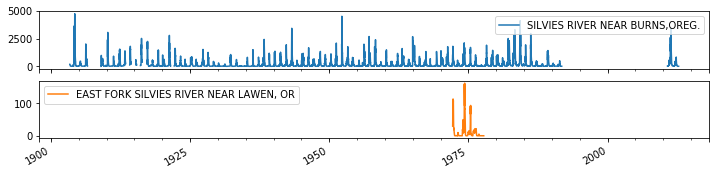

In [6]:
#make dataframe with datetime index for all flows
dtindex = pd.date_range(start=startdate, end=enddate)
df = pd.DataFrame(index=dtindex)

for i in range(0,len(flowdata)):
    dates = [r[0] for r in flowdata[i].data]
    flow = [r[1] for r in flowdata[i].data]
    flowseries = pd.Series(data = flow, index=dates)
    df[flowdata[i].site_name] = flowseries

#plot subplots to see data extent, with 1.3 inch high subplots
df.plot(subplots=True, figsize=(12,len(flowdata)*1.3)) 


In [11]:
#choose a station for flow data and name it
station_id = '07170500'
station_name = 'Verdigris at Independence'
myflowstation = DailyValueIO(
    start_date=startdate,
    end_date=enddate,
    station=station_id,
    parameter="00060" #daily flow in cfs
)


In [12]:
#after some inspection of the returned object, this is what we need:
dates = [r[0] for r in myflowstation[0][7]]
flows = [r[1] for r in myflowstation[0][7]]
stationflows = pd.DataFrame(flows,index=dates, columns=[station_name])
stationflows.index = pd.to_datetime(stationflows.index)        

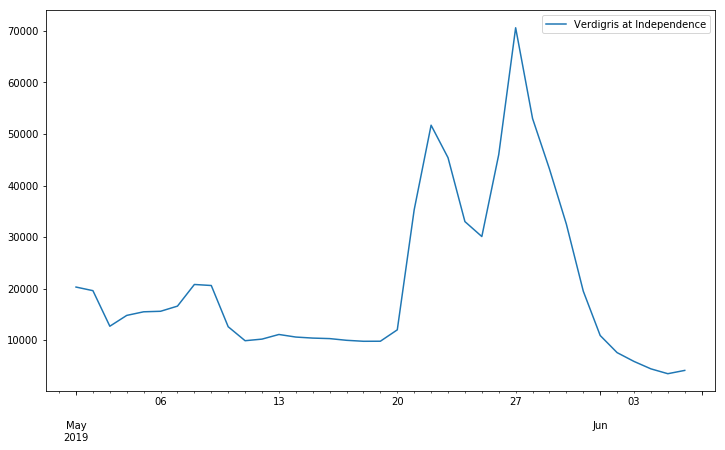

In [16]:
stationflows['2019-05-01':'2019-06-06'].plot(figsize=(12,7))

## Flashiness
is the variability, and in this case we are dealing with daily values of streamflow and precipitation.

In [17]:
def flashiness(series):
    """Richards-Baker Flashiness Index for a Pandas series of daily mean flows = the path length (ups and downs) divided by the sum. WARNING: if the sum is zero (for example in a series with missing records replaced with zeros) this will result in an error, so this function returns zero instead."""
    Qsum = np.sum(series)  # sum of daily flows
    # the path length, or sum of differences between adjacent daily flows:
    Qpath = np.sum(pd.Series(np.abs(series.shift(1)-series))) 
    if Qsum == 0:
        return 0
    else:    
        return round(Qpath/Qsum,2)

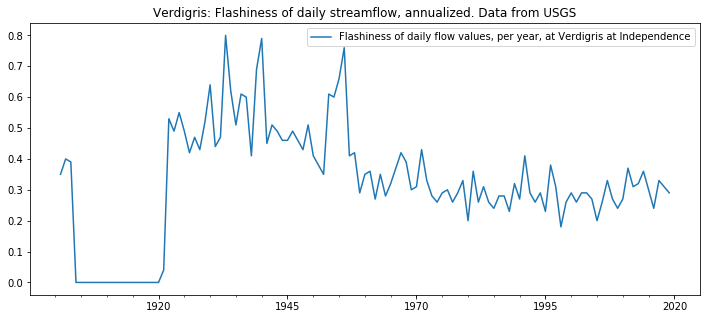

In [18]:
# flashiness of flows. A significant decline often comes from dam construction upstream.
# using pandas Grouper here, with annual frequency ending in December. For California for example, the water year runs from October through September.
flashflows = stationflows.groupby(pd.Grouper(freq='A-DEC')).agg({flashiness})
flashflows.columns=['Flashiness of daily flow values, per year, at '+ station_name]
flashflows.plot(figsize=(12,5))

plt.title(shedName + ': Flashiness of daily streamflow, annualized. Data from USGS')

plt.savefig('charts/' + shedName + 'FlowFlashiness.png',bbox_inches='tight')

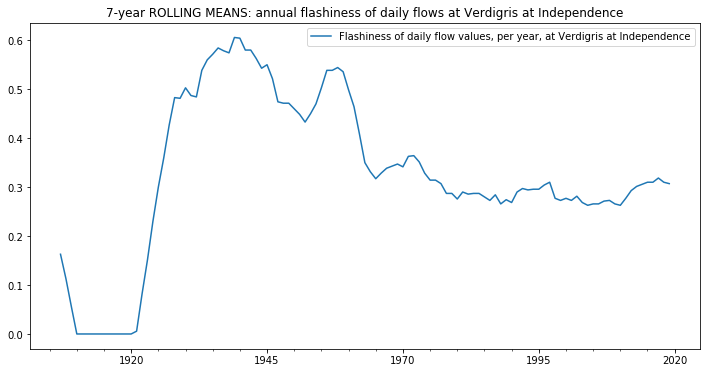

In [19]:
flashflows_rolling = flashflows.rolling(7).mean()
flashflows_rolling.plot(figsize=(12,6))
plt.title('7-year ROLLING MEANS: annual flashiness of daily flows at '+station_name)

plt.savefig('charts/' + shedName + 'FlowFlashinessRolling.png',bbox_inches='tight')

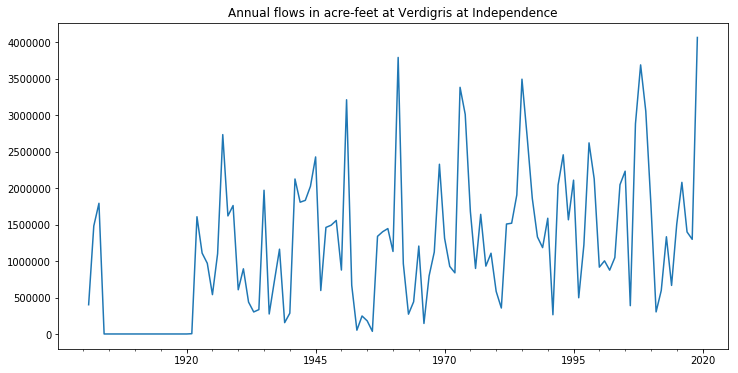

In [20]:
# SUM of flows -- a different grouping function
# by water year, ending in SEP, or calendar year, ending in DEC
annualflows = stationflows.groupby(pd.Grouper(freq='A-DEC')).agg({np.sum})
annualflows.columns = ['sum']
#convert sum of daily cfs to acre-feet
annualflows['acre-feet'] = (annualflows['sum']*60*60*24)/(208*208)
annualflows = annualflows['acre-feet']
#select date range depending on data availability
# annualflows= annualflows[startyear:endyear]
annualflows.plot(figsize=(12,6))
#this is the sum, by year, of the daily average cubic feet per second.

plt.title('Annual flows in acre-feet at '+station_name)

plt.savefig('charts/' + shedName + '_annual_flows.png',bbox_inches='tight')

# Precipitation

In [9]:
#what are available precipitation gauges in the basin for our date range?
pdata = StationDataIO(
    start_date=startdate,
    end_date=enddate,
    basin=shed,
    parameter="pcpn",
)
list(pdata) 

[StationDataIOTuple(name='FREDONIA', sids={'COOP': '142894', 'GHCN': 'USC00142894', 'NWSLI': 'FRNK1'}, county='20205', state='KS', elev=893.0, climdiv='KS09', uid=7281, longitude=-95.827, latitude=37.534, data=<climata.acis.DataIO object at 0x0000015F5804E470>),
 StationDataIOTuple(name='FALL RIVER LAKE', sids={'COOP': '142686', 'GHCN': 'USC00142686', 'NWSLI': 'FLLK1'}, county='20073', state='KS', elev=1031.0, climdiv='KS09', uid=7304, longitude=-96.078, latitude=37.6475, data=<climata.acis.DataIO object at 0x0000015F4E1F6400>),
 StationDataIOTuple(name='CLIMAX', sids={'COOP': '141602', 'GHCN': 'USC00141602'}, county='20073', state='KS', elev=1040.0, climdiv='KS09', uid=7316, longitude=-96.23333, latitude=37.71667, data=<climata.acis.DataIO object at 0x0000015F5804E400>),
 StationDataIOTuple(name='EUREKA 1E', sids={'COOP': '142622', 'GHCN': 'USC00142622', 'NWSLI': 'EKAK1'}, county='20073', state='KS', elev=1100.0, climdiv='KS09', uid=7329, longitude=-96.2644, latitude=37.8253, data=<cl

In [61]:
# create a dataframe of precipitation records called p
for i in range(0,len(pdata)):
    if i==0:
        dates = [r[0] for r in pdata[i].data]
        pcpn = [r[1] for r in pdata[i].data]
        p = pd.DataFrame(data = pcpn, columns = [pdata[i].name], index=dates)
    else:
        p[pdata[i].name] = [r[1] for r in pdata[i].data]
#make sure it's a datetime index
p.index = pd.to_datetime(p.index)
p.describe()

,FREDONIA,FALL RIVER LAKE,CLIMAX,EUREKA 1E,FREDONIA RIVER 1S,EUREKA 2.0 N,FREDONIA 0.3 NNW,FREDONIA 5.9 SW,FREDONIA 1.3 W,EUREKA 0.9 NW,EUREKA 5.4 SSE,CLIMAX 0.8 ENE
count,43385.0,43385.0,43385,43385.0,43385,43385,43385,43385,43385,43385,43385,43385
unique,385.0,410.0,131,337.0,38,87,139,160,60,165,85,61
top,0.0,0.0,M,0.0,M,M,M,M,M,M,M,M
freq,29592.0,23605.0,41283,28407.0,43237,42561,41836,41527,43223,40748,42899,43227


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015F07450748>,
      dtype=object)

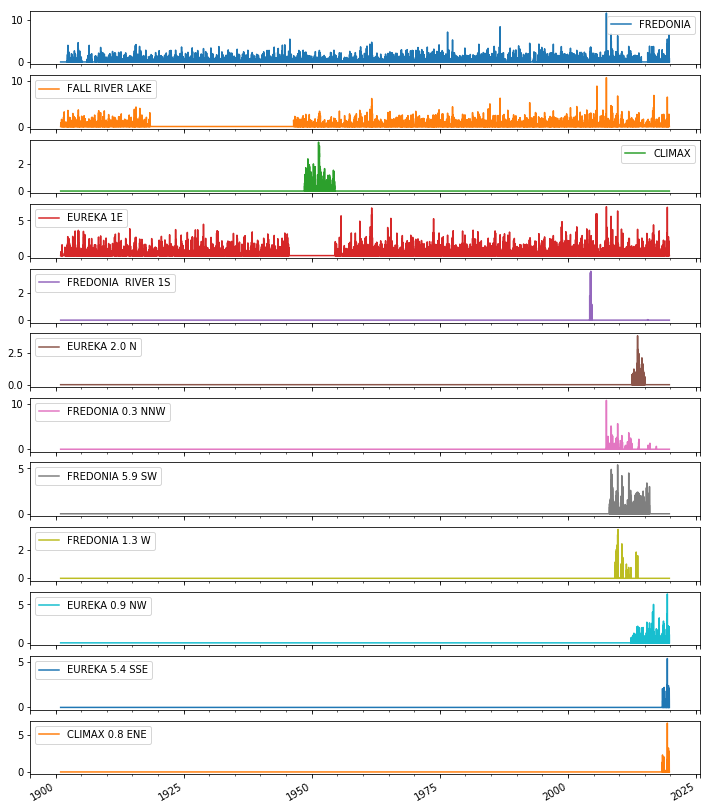

In [62]:
#replace text values so they can be plotted
p.replace(to_replace = ['M','T','S','A'], value=0, regex=True, inplace=True)
p.plot(subplots=True, figsize=(12,len(pdata)*1.3))

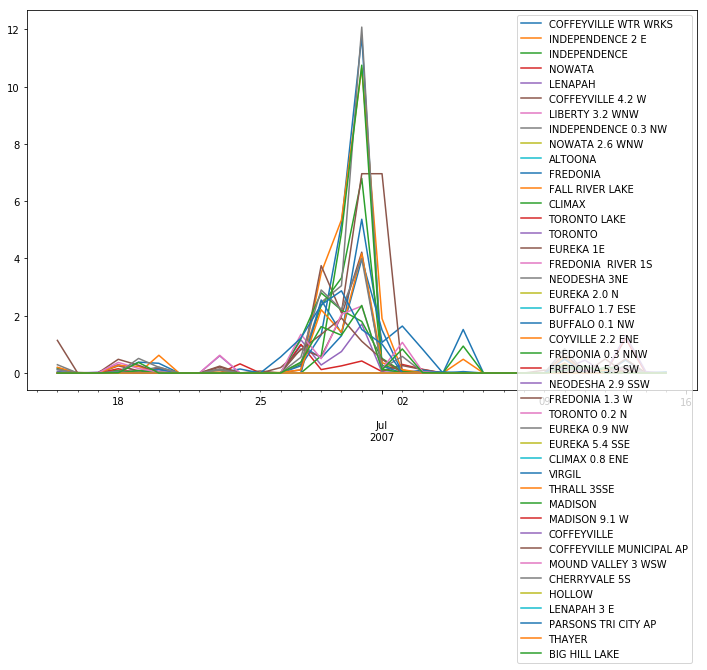

In [30]:
flood1951 = p['2007-06-15':'2007-07-15'].plot(figsize=(12,7))

In [63]:
#NOW CHOOSE the best precipitation stations to use with most complete data
bestgauges = ['CLIMAX', 'FREDONIA','FALL RIVER LAKE','EUREKA 1E','INDEPENDENCE','MADISON']
#p is the actual precip data
p=p[bestgauges]
# fredonia = p['FREDONIA']

# Turbidity
Looking at PWWS 23 turbidity charts and comparing with precip

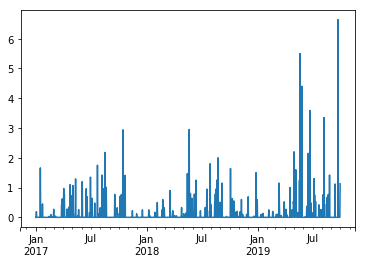

In [64]:
fredonia = fredonia['2017-01-01':'2019-09-30']
fredonia.plot()

In [85]:
ntu = pd.read_excel('FredoniaNTU.xls')
ntu = pd.melt(ntu)
ntu = ntu.dropna()
ntu = ntu['value']
ntu.to_csv('ntu.csv',index=False)


In [109]:
ntu=pd.read_excel('ntu.xls')
ntu.dtypes

NTU    int64
dtype: object

In [111]:
fredonia = fredonia['FREDONIA']
fredonia.dtypes


dtype('float64')

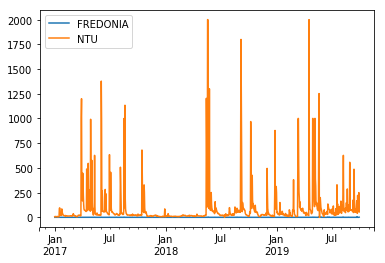

In [125]:
df = fredonia.to_frame()
df['NTU'] =ntu.values
df.plot()

In [119]:
df

,FREDONIA,NTU
2017-01-01,0.00,NaN
2017-01-02,0.00,NaN
2017-01-03,0.19,NaN
2017-01-04,0.00,NaN
2017-01-05,0.00,NaN
2017-01-06,0.00,NaN
2017-01-07,0.00,NaN
2017-01-08,0.00,NaN
2017-01-09,0.00,NaN
2017-01-10,0.00,NaN


In [49]:
df['ntu'] = list(ntu).astype(int64)
df.columns = ['precip', 'NTU']
df

,precip,NTU
2017-01-01,0,6
2017-01-02,0,9
2017-01-03,0.19,7
2017-01-04,0,7
2017-01-05,0,6
2017-01-06,0,7
2017-01-07,0,6
2017-01-08,0,6
2017-01-09,0,7
2017-01-10,0,9


In [51]:
df.dtypes

precip    object
NTU       object
dtype: object

In [32]:
p['ntu'] = ntulist
p

2017-01-01 00:00:00                                                    0
2017-01-02 00:00:00                                                    0
2017-01-03 00:00:00                                                 0.19
2017-01-04 00:00:00                                                    0
2017-01-05 00:00:00                                                    0
2017-01-06 00:00:00                                                    0
2017-01-07 00:00:00                                                    0
2017-01-08 00:00:00                                                    0
2017-01-09 00:00:00                                                    0
2017-01-10 00:00:00                                                    0
2017-01-11 00:00:00                                                    0
2017-01-12 00:00:00                                                    0
2017-01-13 00:00:00                                                    0
2017-01-14 00:00:00                                

In [32]:
#basic stations dataframe for mapping etc.
pstations = pd.DataFrame([[y for y in x] for x in pdata],
columns=['name','codes','county','st','r','a','b','lon','lat','data'])

#filter the pstations dataframe and map these
pstations = pstations.loc[pstations['name'].isin(bestgauges)]
m = folium.Map(location=[pstations['lat'].mean(), pstations['lon'].mean()], zoom_start=9, tiles="Stamen Terrain")
for i in range(0,len(pstations)):
    tooltip = pstations.iloc[i]['name']
    folium.Marker([pstations.iloc[i]['lat'], pstations.iloc[i]['lon']],tooltip=tooltip).add_to(m)

#include the HUC8 boundaries downloaded from Google Earth and converted by https://mapbox.github.io/togeojson/
folium.GeoJson('C:/Users/Peter/Documents/atlas/notebooks/geojson/white.geojson',
    name='HUC8 boundaries',
    style_function=huc8_borders,
    ).add_to(m)
    
m

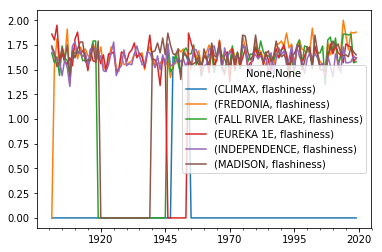

In [33]:
precipFlash = p.groupby(pd.Grouper(freq='A-DEC')).agg({flashiness})
precipFlash.plot()

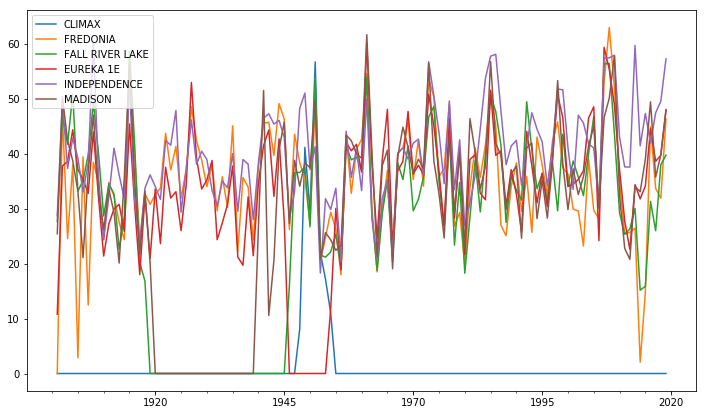

In [34]:
pgroup = p.groupby(pd.Grouper(freq='A-DEC')).agg({np.sum})
pgroup.columns = bestgauges
pgroup.plot(figsize=(12,7))


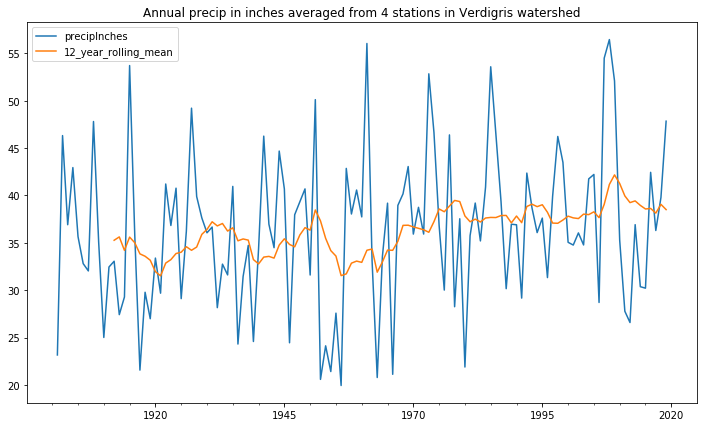

In [36]:
#replace 0s with NaN, partial years (e.g. < 14 inches) so we can get mean of rows, rename as df
annualprecip = pgroup.mask(pgroup < 10)
annualprecip['precipInches'] = annualprecip.mean(axis=1)
annualprecip = annualprecip.drop(bestgauges, axis=1)
annualprecip['12_year_rolling_mean'] = annualprecip['precipInches'].rolling(12).mean()
annualprecip.plot(figsize=(12,7))
plt.title('Annual precip in inches averaged from 4 stations in '+shedName+ ' watershed')

plt.savefig('charts/' + shedName + '_avg_precip.png',bbox_inches='tight')

## Precip from CHIRPS via Earth Engine

This dataset is only available from 1981 on. If you are signed in as Google Earth Engine developer, you can get average yearly rainfall for a geometry, and export a csv to your drive.

IF YOU ARE NOT USING CHIRPS YOU SHOULD SKIP THIS SECTION




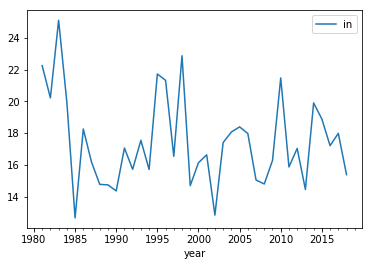

In [34]:

#example from Catherine Creek in Oregon, processing a kind of awkward csv
chirps = pd.read_excel('csv/SenecaCHIRPS.xls')
# chirps = chirps.transpose()
# chirps.drop(chirps.tail(1).index,inplace=True)
# chirps.drop(chirps.head(1).index,inplace=True)
# chirps['CHIRPS'] = (chirps[0])/(25.4) #convert mm to inches
# chirps['CHIRPS'].plot()
chirps.set_index('year', inplace=True)
chirps.index = pd.to_datetime(chirps.index, format='%Y')
chirps.plot()

In [34]:
#create datetimeindex for CHIRPS
years = pd.date_range(start=pd.datetime(1981, 12, 31), periods=38, freq='A')
chirps = chirps.set_index(years)
chirps.drop(0, axis=1,inplace=True)


,CHIRPS
1981-12-31,18.933840
1982-12-31,20.747373
1983-12-31,20.861381
1984-12-31,20.776014
1985-12-31,15.884890
1986-12-31,18.627738
1987-12-31,12.903596
1988-12-31,16.381529
1989-12-31,16.749198
1990-12-31,17.531218


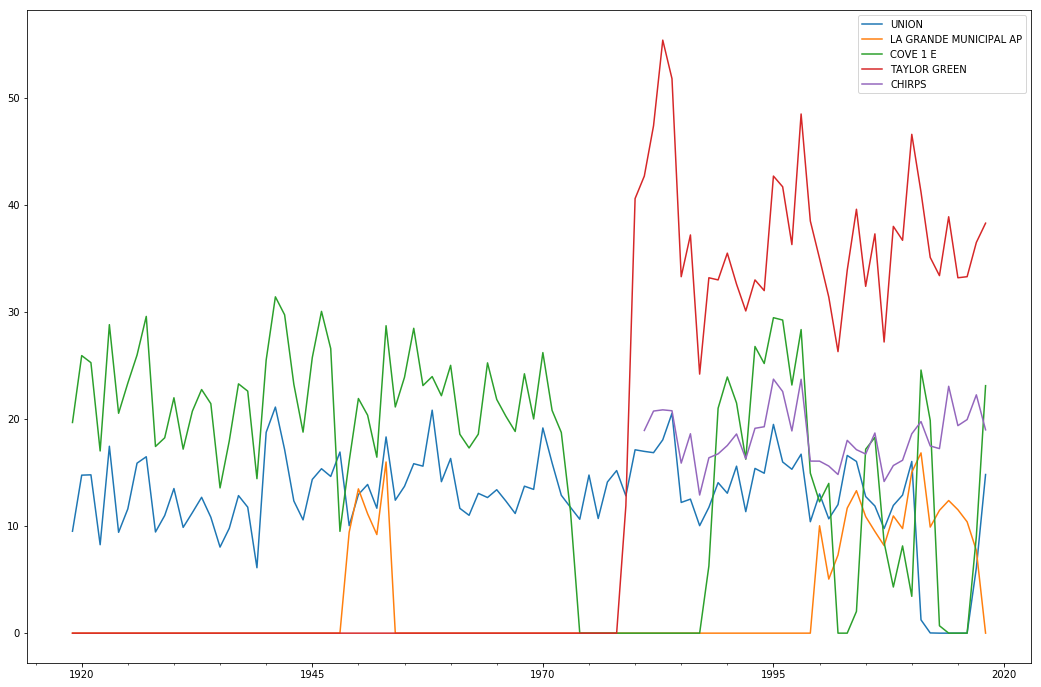

In [35]:
# now we have the same index, and can compare to CHIRPS to gauges
merged = pgroup.join(chirps, how='outer')
# merged.plot(figsize=(18,12))

In [ ]:
chirps = merged['1981':'2018']
chirps = chirps.drop(bestgauges, axis=1)
merged = merged.drop('CHIRPS', axis=1)
merged=merged['1960':'1980']
merged['CHIRPS'] = merged.mean(axis=1)
merged = merged.drop(bestgauges, axis=1)
precip = pd.concat([merged,chirps], axis=0)
precip.columns=['rainfall']

## End CHIRPS section

Now we can merge flows and precipitation and calculate runoff ratios

In [37]:
#convert annual precip inches to acre-feet in the basin
annualprecip['precipAF'] = annualprecip['precipInches']*2287998/12
annualprecip = annualprecip['precipAF']

In [38]:
#join precip with streamflow
df = pd.concat([annualflows, annualprecip],axis=1)

In [39]:
df.columns=['flowAF','precipAF']
df['runoff_ratio']=df['flowAF']/df['precipAF']


In [40]:
#get rolling means
roll_period = 10
df['flowRolling'] = df['flowAF'].rolling(roll_period).mean()
df['precipRolling'] = df['precipAF'].rolling(roll_period).mean()
#runoff ratio
df['ratioRolling'] = df['runoff_ratio'].rolling(roll_period).mean()

df.to_csv('csv/' + shedName + '_' + str(roll_period) +'rolling.csv') #save it

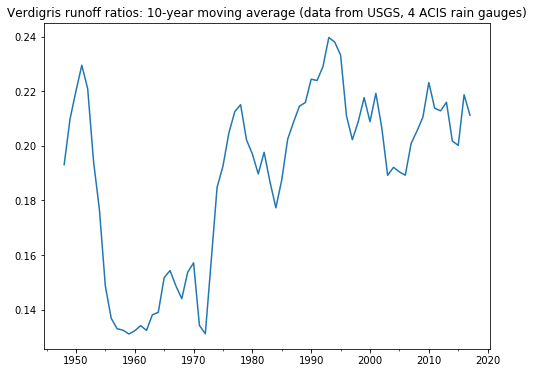

In [41]:
df['1948':'2017']['ratioRolling'].plot(figsize=(8,6))
plt.title(shedName + ' runoff ratios: 10-year moving average (data from USGS, 4 ACIS rain gauges)')

plt.savefig('charts/' + shedName + '_rolling_10_ratio.png',bbox_inches='tight')

In [47]:
df.describe()

,flowAF,precipAF,runoff_ratio,flowRolling,precipRolling,ratioRolling
count,8.100000e+01,1.180000e+02,81.000000,72.000000,1.090000e+02,72.000000
mean,3.832989e+05,1.617749e+06,0.215232,395466.544027,1.623250e+06,0.219722
std,2.624992e+05,3.875540e+05,0.113238,79000.467137,1.122690e+05,0.040001
min,1.605621e+03,8.557947e+05,0.001060,249929.733728,1.404770e+06,0.142967
25%,1.893436e+05,1.328801e+06,0.141890,342333.848743,1.552360e+06,0.187687
50%,3.528674e+05,1.616174e+06,0.214768,402135.041383,1.642961e+06,0.229892
75%,5.230799e+05,1.844299e+06,0.292404,441801.736908,1.692346e+06,0.251999
max,1.155701e+06,2.671932e+06,0.432534,573551.669822,1.867326e+06,0.286646


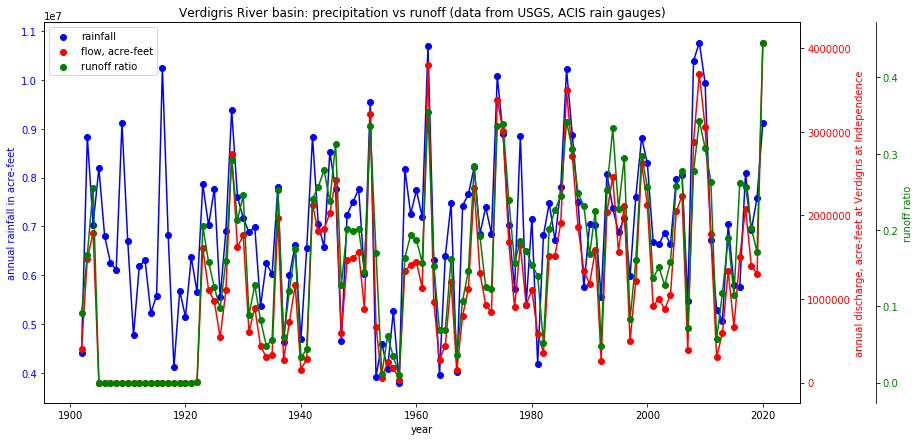

In [42]:
#chart with 3 y axes
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


#make lists of each series        
y1 = list(df['precipAF'])
y2 = list(df['flowAF'])
y3 = list(df['runoff_ratio'])
x = list(df.index)

fig, host = plt.subplots(figsize=(12,7))
fig.subplots_adjust(right=1)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(x, y1, "b-", label="rainfall, acre-feet")
p1 = host.scatter(x, y1, c="b")

p2, = par1.plot(x, y2, "r-", label="flow, acre-feet")
p2 = par1.scatter(x, y2, c="r")

p3, = par2.plot(x, y3, "g-", label="runoff ratio")
p3 = par2.scatter(x, y3, c="g")


# host.set_xlim(0, 2)
# host.set_ylim(0, 60)
# par1.set_ylim(0, 6000000)
# par2.set_ylim(0, .7)

host.set_xlabel("year")
host.set_ylabel("annual rainfall in acre-feet")
par1.set_ylabel("annual discharge, acre-feet at " + station_name)
par2.set_ylabel("runoff ratio")

for tl in host.get_yticklabels():
    tl.set_color('b')
for tl in par1.get_yticklabels():
    tl.set_color('r')
for tl in par2.get_yticklabels():
    tl.set_color('g')
host.yaxis.label.set_color('b')
par1.yaxis.label.set_color('r')
par2.yaxis.label.set_color('g')

host.legend((p1,p2,p3), ('rainfall', 'flow, acre-feet', 'runoff ratio'))
plt.title(shedName + ' River basin: precipitation vs runoff (data from USGS, ACIS rain gauges)')

plt.savefig('charts/' + shedName + '.png',bbox_inches='tight')

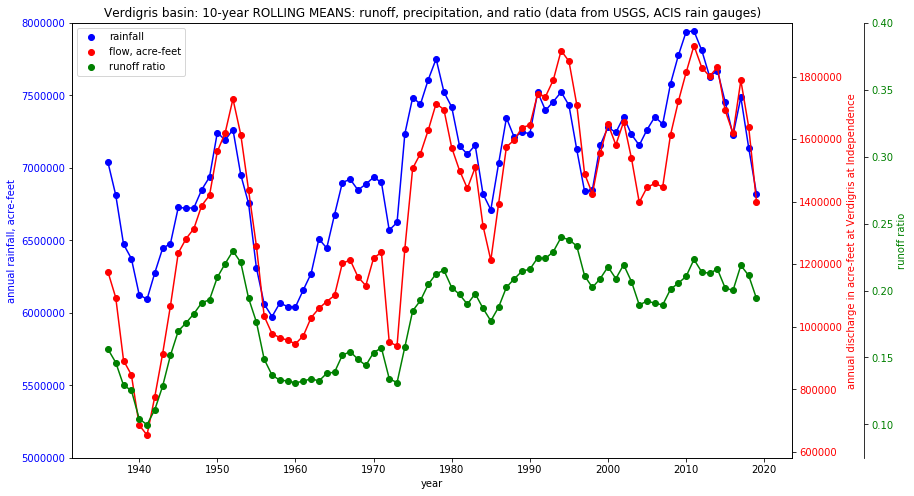

In [54]:
#rolling means
df = df['1935':'2018']
#make lists of each series        
y1 = list(df['precipRolling'])
y2 = list(df['flowRolling'])
y3 = list(df['ratioRolling'])
x = list(df.index)

fig, host = plt.subplots(figsize=(16,8))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(x, y1, "b-", label="rainfall, acre-feet")
p1 = host.scatter(x, y1, c="b")

p2, = par1.plot(x, y2, "r-", label="flow, acre-feet")
p2 = par1.scatter(x, y2, c="r")

p3, = par2.plot(x, y3, "g-", label="runoff ratio")
p3 = par2.scatter(x, y3, c="g")

# adjust y scales so that charts are not on top of each other
# host.set_xlim(0, 2)
# rainfall
host.set_ylim(5000000, 8000000)
# discharge
# par1.set_ylim(0, 1000000)
# ratio
par2.set_ylim(0.075, .4)

host.set_xlabel("year")
host.set_ylabel("annual rainfall, acre-feet")
par1.set_ylabel("annual discharge in acre-feet at " + station_name)
par2.set_ylabel("runoff ratio")

for tl in host.get_yticklabels():
    tl.set_color('b')
for tl in par1.get_yticklabels():
    tl.set_color('r')
for tl in par2.get_yticklabels():
    tl.set_color('g')
host.yaxis.label.set_color('b')
par1.yaxis.label.set_color('r')
par2.yaxis.label.set_color('g')

host.legend((p1,p2,p3), ('rainfall', 'flow, acre-feet', 'runoff ratio'))
plt.title(shedName + ' basin: ' + str(roll_period) +'-year ROLLING MEANS: runoff, precipitation, and ratio (data from USGS, ACIS rain gauges)')

plt.savefig('charts/' + shedName + 'Rolling.png',bbox_inches='tight')

In [127]:
#PRECIP + TURBIDITY
df.columns=['precip at Fredonia','NTU']

In [132]:
df.to_excel('precip_vs_NTU_Fredonia.xls')

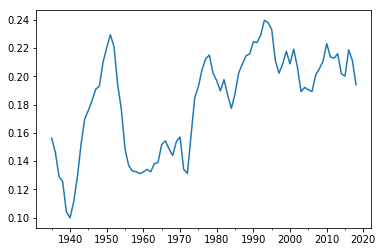

In [47]:
df['ratioRolling'].plot()